In [14]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

import numpy as np

### **The non-Gaussian noise case** 



**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [15]:
METHOD = 'linear'

A = np.array(
          [
              [0.95, 0.00],
              [0.00, 0.80]
          ])

params = [A]

In [16]:
#Initial distribution
initial_position = np.array([8, 8])
var_initial_state = np.array([-0.2, 0.2])

#Noise structure
var_noise = np.array([-0.3, 0.3])

#Steps ahead for prediction
n_steps_ahead = 10

In [17]:
unbounded_region = np.array([[np.inf, np.inf], [np.inf, np.inf]]) #a representation choice for the unbounded region

In [18]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [19]:
barriers_list = barriers.createBarrier(np.array([[4, 2], [6, 4]]))
barrier = barriers_list[0]

In [20]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_12116\2522582876.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [21]:
import random

def sampleUniformVector(interval, size):
    sampled_vectors = []
    for _ in range(size):
        x = random.uniform(interval[0], interval[1])
        y = random.uniform(interval[0], interval[1])
        sampled_vectors.append([x, y])
    return np.array(sampled_vectors)

def systemNoiseNonGaussian(interval, size):

    noise_samples = sampleUniformVector(interval, size)

    return noise_samples

def stateOneStepEvolutionNonGaussian(current_state, interval, method, params):
    
    size_samples = current_state.shape[0]

    noise = systemNoiseNonGaussian(interval, size_samples)

    return propag.systemDynamics(current_state, method, params) + noise


def getInitialState(initial_position, var, size):

    initial_state_samples = initial_position + systemNoiseNonGaussian(var, size)

    return np.array(initial_state_samples)

Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.00018
Hitting proba: 0.06228
Hitting proba: 0.30278
Hitting proba: 0.39296
Hitting proba: 0.11276
Hitting proba: 0.00808
Hitting proba: 0.00014
Hitting proba: 0.0


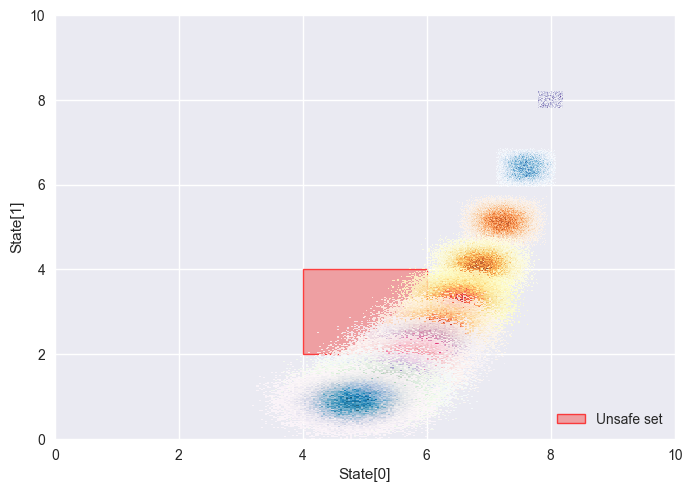

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_simulations = 50_000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        states = getInitialState(initial_position, var_initial_state, n_simulations)
    else:
        states = stateOneStepEvolutionNonGaussian(states, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower right')

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### TV bounds

In [23]:
import numpy as np

def compute_intersection(interval1, array_intervals):

    # Compute the start and end points of the intersection
    start = np.maximum(interval1[0], array_intervals[:, 0])
    end = np.minimum(interval1[1], array_intervals[:, 1])

    # Check if there is no overlap
    mask = start > end
    start[mask] = 0
    end[mask] = 0

    return np.column_stack((start, end))



def computeSignatureProbabilities(regions, centers, var, weights):
    
    signature_probas = []

    factor = 1/(var[1] - var[0])**2

    lines_x = centers[:, 0][:, np.newaxis] + var
    lines_y = centers[:, 1][:, np.newaxis] + var

    for region in regions:

        line_region_x = np.array([region[0][0], region[1][0]])
        line_region_y = np.array([region[0][1], region[1][1]])
        
        proba_region = 0

        x_intersections = compute_intersection(line_region_x, lines_x)
        y_intersections = compute_intersection(line_region_y, lines_y)

        length_x = x_intersections[:, 1] - x_intersections[:, 0]
        length_y = y_intersections[:, 1] - y_intersections[:, 0]

        proba_region = np.sum(weights[:, np.newaxis] * factor * length_x * length_y, axis=1)[0]

        signature_probas.append(proba_region)

    signature_probas = np.array(signature_probas)
    
    # the remaining probability is attributed to the whole unbounded region
    unbounded_proba = 1 - signature_probas.sum()
    signature_probas = np.concatenate((signature_probas, [unbounded_proba]))

    return signature_probas


In [24]:
def sampleFromGMM(n_samples, weights, means, var):
                
    sampled_points = []

    for i in range(n_samples):
        
        index_normal = np.random.choice(len(weights), p = weights)

        sample_from_component = means[index_normal] + sampleUniformVector(var, 1)

        sampled_points.append(sample_from_component[0])

    return np.array(sampled_points)

In [25]:
def computeUpperBoundForTVWithMax(signatures, regions, probas, var_noise, method, params):

    tv = 0

    contributions = []

    C_1 = 1/(var_noise[1] - var_noise[0])
    C_2 = 1/(var_noise[1] - var_noise[0])

    for cont, (signature, region) in enumerate(zip(signatures, regions)):
        
        max_value = 0
        prob_gmm_region = 0

        if bounds.verifyIfRegionIsBounded(region):

            vertices = grid.getVertices(region)
            
            max_value_1, max_value_2 = 0, 0

            for vertice in vertices:

                max_value_1 = max(max_value_1, C_1 * abs( np.dot(A, vertice)[0] - np.dot(A, signature)[0] ))
                max_value_2 = max(max_value_2, C_2 * abs( np.dot(A, vertice)[1] - np.dot(A, signature)[1] ))

            #TV is smaller than 1
            max_value_1 = min(max_value_1, 1)
            max_value_2 = min(max_value_2, 1)

            max_value = max_value_1 + max_value_2

        else:
            max_value = 1

        
        prob_gmm_region = probas[cont]

        contributions.append(max_value*prob_gmm_region)

        tv += max_value*prob_gmm_region

    return tv, contributions

Number of regions:  17
0.1458673321001878
Number of regions:  65
0.07295546639052558
Number of regions:  257
0.03649953353569423
Number of regions:  1025
0.018271567108279207
Number of regions:  4097
0.00915758389457087
Number of regions:  16385
0.004600592287717036


KeyboardInterrupt: 

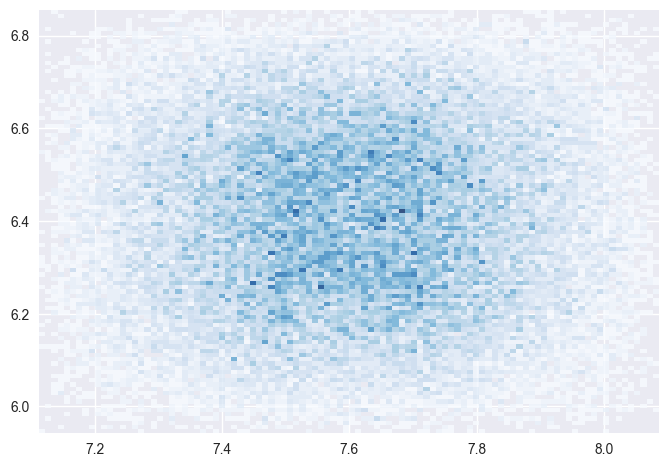

In [26]:
n_samples = 50_000

min_proportion = 0.1
min_size = 0.01
n_refinements = 6

tv_bounds = [0.0]
gmm_hitting_proba = [0.0]


fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):

    if t == 0:
        hat_gmm = [np.array([1.0]), np.array([initial_position]), var_initial_state]
    else:
        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        hat_gmm = [double_hat_proba, means_gmm, var_noise]

        # #Compute hitting probability
        # proba_barrier = gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        # gmm_hitting_proba.append(proba_barrier)

    samples = sampleFromGMM(n_samples, hat_gmm[0], hat_gmm[1], hat_gmm[2])

    plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    if t < n_steps_ahead:

        vertice_lower, vertice_upper = grid.findMinMaxPoints(samples)

        hpr = np.array([vertice_lower, vertice_upper])

        outer_signature = grid.computeOuterPoint(hpr)

        regions = np.array(grid.subdivideRegion(hpr, samples, min_proportion, min_size))

        signatures = grid.placeSignatures(regions)

        #double_hat_proba = computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
        double_hat_proba = computeSignatureProbabilities(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])

        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
        print('Number of regions: ', len(regions))

        tv_bound, contributions = computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)
        print(tv_bound)

        for r in range(n_refinements):

            if tv_bound > 0.006:

                regions, signatures = grid.refineRegions(regions, signatures, contributions, 1e-7)
                regions = regions[:-1]
                signatures = signatures[:-1]
                #double_hat_proba = computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
                double_hat_proba = computeSignatureProbabilities(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
                regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
                print('Number of regions: ', len(regions))

                tv_bound, contributions = computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)
                print(tv_bound)

        tv_bounds.append(tv_bound)


plt.legend(loc='lower right')

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### TV contribution per region

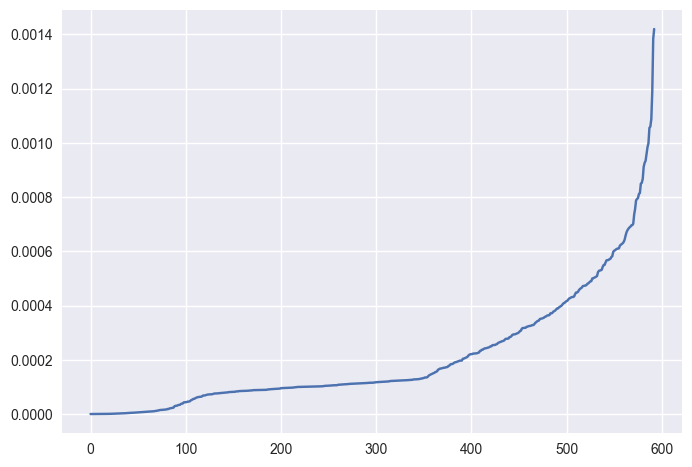

In [ ]:
contributions = np.array(contributions)
contributions = np.sort(contributions)
plt.plot(contributions)

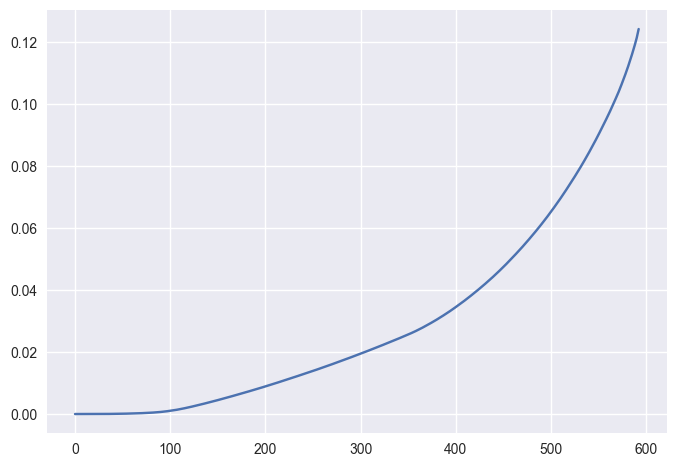

In [ ]:
plt.plot(np.cumsum(contributions))

In [ ]:
import matplotlib.pyplot as plt

def draw_square(x_min, y_min, x_max, y_max):
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='blue')

def plot_regions(regions):
    for region in regions:
        x_min, y_min = region[0]
        x_max, y_max = region[1]
        draw_square(x_min, y_min, x_max, y_max)
    plt.xlabel('State[0]')
    plt.ylabel('State[1]')
    plt.grid(True)
    plt.axis('equal')  # Set equal aspect ratio
    plt.show()

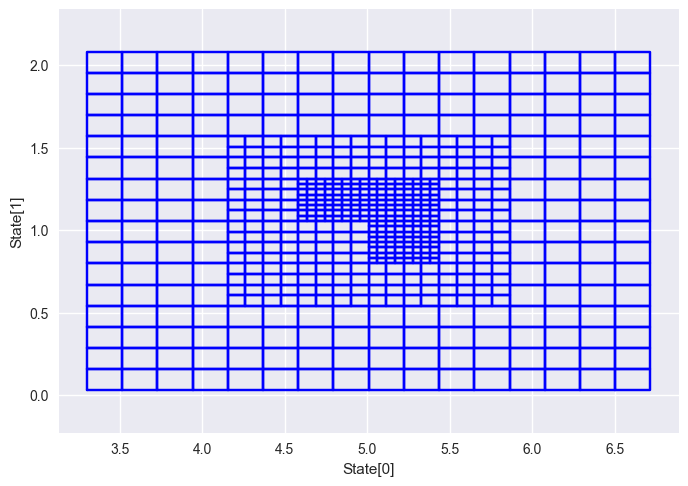

In [ ]:
plot_regions(regions)

##### Compare hitting probabilities

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_15656\1569244730.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


ValueError: 'yerr' (shape: (11,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

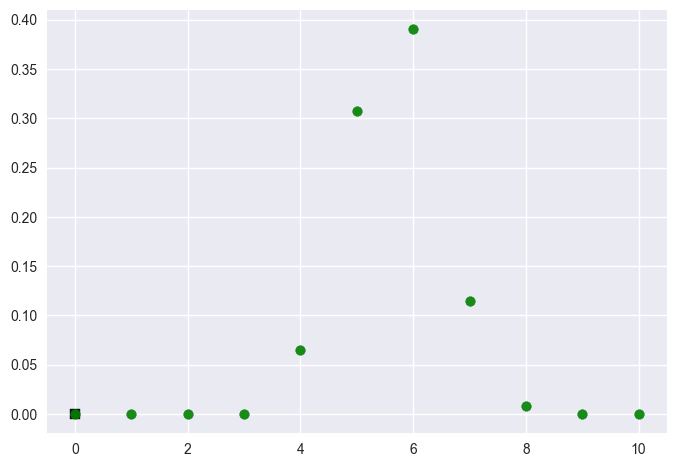

In [ ]:
#Compute TV bounds
tv_bounds_cumul = np.cumsum(tv_bounds)

plt.style.use("seaborn")

# Plotting
plt.scatter(range(len(mc_hitting_proba)), mc_hitting_proba, color='green', alpha = 0.9, label = f'Monte Carlo ({n_simulations:.0e} samples)', zorder=3)
plt.scatter(range(len(gmm_hitting_proba)), gmm_hitting_proba, color='black', alpha = 0.9, marker='s', label = f'GMM approx. ({n_samples:.0e} samples)', zorder=2)

# Adding error bars for gmm_probas
plt.errorbar(range(len(gmm_hitting_proba)), gmm_hitting_proba, yerr = tv_bounds_cumul, fmt='none', color='black', alpha = 0.9, capsize=5, label='TV bounds', zorder=1)

plt.ylim(0, 1)
plt.xticks(range(len(mc_hitting_proba)))

plt.xlabel('Time step')
plt.ylabel('Hitting probability')
plt.legend()
plt.show()

##### TV bounds

In [ ]:
tv_bounds_cumul

array([0.])